# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Châu Tấn Kiệt
- MSSV: 21127329
- Lớp: 21CLC4

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Import thêm dữ thư viện nếu cần

# Đọc dữ liệu

In [2]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
label_train, label_test = train.columns, test.columns
x_train = train.iloc[:, :-1].to_numpy()   # Dataframe (chứa 10 đặc trưng huấn luyện)
y_train = train.iloc[:, -1].to_numpy()    # Series    (chứa 1 giá trị mục tiêu kiểm tra)

x_test = test.iloc[:, :-1].to_numpy()     # Dataframe (chứa 10 đặc trưng kiểm tra)
y_test = test.iloc[:, -1].to_numpy()      # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

# Cài đặt hàm

In [3]:
def MAE(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

def findFormula(a, b):
    print('Intercept: \n', b)
    print('Coefficients: \n', a)

def LinearRegression(a, b):
    reg = linear_model.LinearRegression().fit(a, b)
    return reg.coef_, reg.intercept_

def CrossValidation(a, b, kfold):
    kf = KFold(n_splits=kfold, shuffle = True)
    error_list = []

    for train_index, test_index in kf.split(a):
        A_train, A_test = a[train_index], a[test_index]
        b_train, b_test = b[train_index], b[test_index]
        x, bias = LinearRegression(A_train, b_train)
        error_list.append(MAE(b_test,(np.dot(A_test, x) + bias)))

    return np.mean(error_list)

def chooseBestProperty(a, b):
    result = []

    for i in range(a.shape[1]):
        cv_prop = CrossValidation(a[:, i:i + 1], b, 10)
        result.append(cv_prop)
    
    return result, np.argmin(result)

## Xử lý outlier bằng thuật toán IQR 
def replace_outliers_with_iqr(data_frame, column_name):
    Q1 = data_frame[column_name].quantile(0.25)
    Q3 = data_frame[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median_value = data_frame[column_name].median()
    data_frame[column_name] = np.where((data_frame[column_name] < lower_bound) | (data_frame[column_name] > upper_bound), median_value, data_frame[column_name])


# Yêu cầu 1a: Sử dụng toàn bộ 11 đặc trưng đầu tiên `Gender`, `10percentage`, `12percentage`, `CollegeTier`, `Degree`, `collegeGPA`, `CollegeCityTier`, `English`, `Logical`, `Quant`, `Domain` (2 điểm) 

In [4]:
## Phần code cho yêu cầu 1a
first11 = train[['Gender', '10percentage','12percentage', 'CollegeTier','Degree', 'collegeGPA','CollegeCityTier', 'English','Logical', 'Quant','Domain']]

In [5]:
x_a, bias_a = LinearRegression(first11.to_numpy()[:,:], y_train)

In [6]:
first11_test = test[['Gender', '10percentage','12percentage', 'CollegeTier','Degree', 'collegeGPA','CollegeCityTier', 'English','Logical', 'Quant','Domain']]
first11_pred = bias_a + np.sum(x_a * first11_test, axis = 1)

In [7]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
MAE(y_test, first11_pred)

105052.52978823145

In [8]:
# Tìm công thức
findFormula(x_a,bias_a)

Intercept: 
 49248.089734813664
Coefficients: 
 [-23183.32950765    702.76679172   1259.0187879  -99570.60814074
  18369.9624496    1297.53200035  -8836.727123      141.75993906
    145.74234652    114.64331342  34955.75040521]


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 49248.090 - 23183.330{Gender} + 702.767{10percentage} +  1259.018{12percentage} - 99570.608{CollegeTier} 
+ 18369.962{Degree}\\ + 1297.532{collegeGPA} - 8836.727{CollegeCityTier} + 141.760{English} + 145.742{Logical} +114.643{Quant} + 34955.750{Domain}$$

# Yêu cầu 1b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng tính cách với các đặc trưng tính cách gồm `conscientiousness`, `agreeableness`, `extraversion`, `nueroticism`, `openess_to_experience`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [9]:
# Phần code cho yêu cầu 1b
# In ra các kết quả cross-validation như yêu cầu
personality = train[['conscientiousness','agreeableness', 'extraversion', 'nueroticism', 'openess_to_experience']]
error_list_b, best_index_b = chooseBestProperty(personality.to_numpy(), y_train)
cv_list_b = dict(zip(personality.columns, error_list_b))
for c in cv_list_b: 
    print (f'Cross-validation error for {c}: {cv_list_b[c]}')

Cross-validation error for conscientiousness: 124169.09517901202
Cross-validation error for agreeableness: 123640.73419075347
Cross-validation error for extraversion: 123922.10343933331
Cross-validation error for nueroticism: 123528.7389669989
Cross-validation error for openess_to_experience: 123739.04792044165


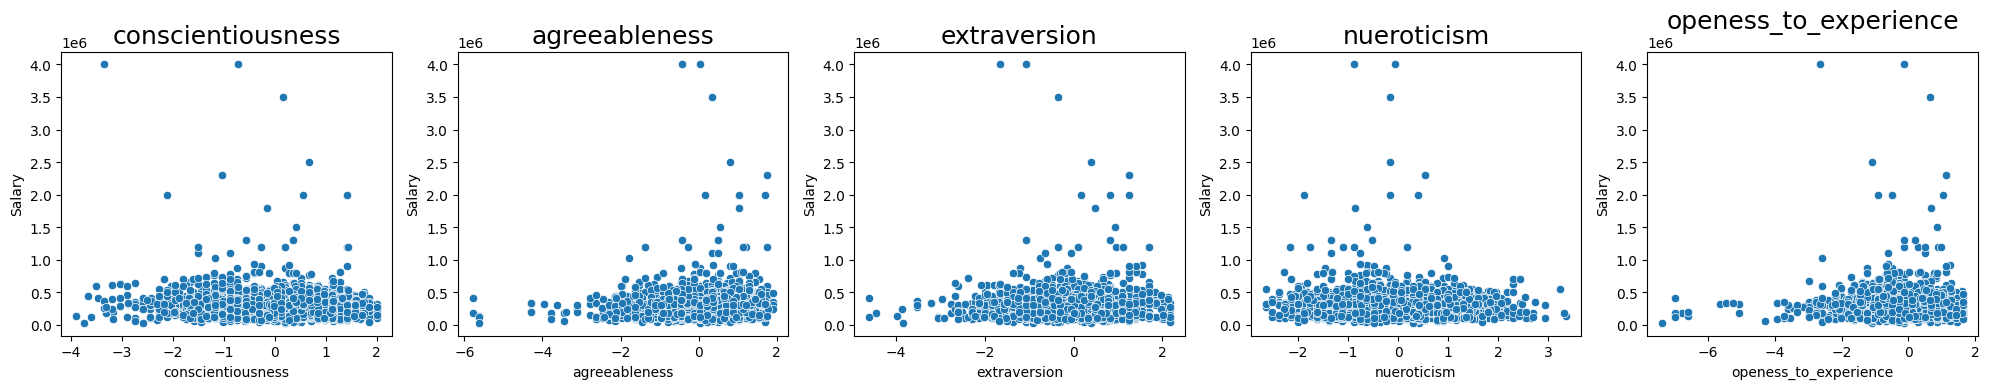

In [10]:
plt.figure(figsize=(20,4))
plt.subplots_adjust(wspace=0.3)

for i, s in enumerate(personality):
    plt.subplot2grid((1, 5), (0,i))
    sns.scatterplot(x=train[s], y=train['Salary']).set_title(s, fontsize=18)

plt.tight_layout()
plt.show()

In [11]:
# Tìm ra đặc trưng tốt nhất
print(f'Best personality is: {personality.columns[best_index_b]}')
print(f'Cross-validation error: {error_list_b[best_index_b]}')


Best personality is: nueroticism
Cross-validation error: 123528.7389669989


In [12]:
# Huấn luyện lại mô hình best_personality_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
x_b, bias_b = LinearRegression(personality.to_numpy()[:, best_index_b:best_index_b + 1], y_train)

In [13]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
per_test = test[['nueroticism']]
per_test_pred = bias_b + x_b * per_test

In [14]:
MAE(y_test, per_test_pred)

120007.64898995696

In [15]:
# Tìm công thức
findFormula(x_b, bias_b)

Intercept: 
 304647.55255226186
Coefficients: 
 [-16021.49366179]


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 304647.553 - 16021.494{Nueroticism}$$

# Yêu cầu 1c: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng `English`, `Logical`, `Quant`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [16]:
# Phần code cho yêu cầu 1c
skill = train[['English','Logical', 'Quant']]
error_list_c, best_index_c = chooseBestProperty(skill.to_numpy(), y_train)

# In ra các kết quả cross-validation như yêu cầu
cv_list_c = dict(zip(skill.columns, error_list_c))
for c in cv_list_c: 
    print (f'Cross-validation error for {c}: {cv_list_c[c]}')


Cross-validation error for English: 120693.66831851506
Cross-validation error for Logical: 120079.63643267068
Cross-validation error for Quant: 117387.43161323566


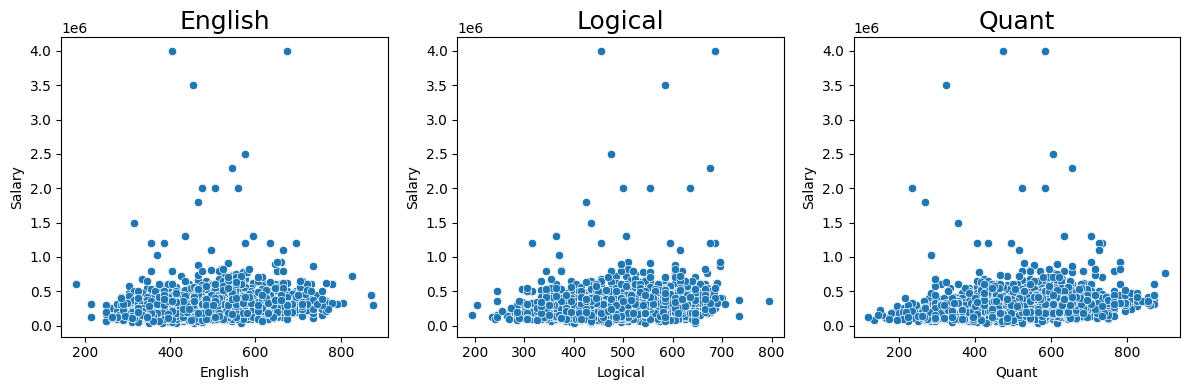

In [17]:
plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.3)

for i, s in enumerate(skill):
    plt.subplot2grid((1, 3), (0,i))
    sns.scatterplot(x=train[s], y=train['Salary']).set_title(s, fontsize=18)

plt.tight_layout()
plt.show()

In [18]:
# Tìm ra đặc trưng tốt nhất
print(f'Best attribute is: {skill.columns[best_index_c]}')
print(f'Cross-validation error: {error_list_c[best_index_c]}')


Best attribute is: Quant
Cross-validation error: 117387.43161323566


In [19]:
# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
x_c, bias_c = LinearRegression(skill.to_numpy()[:, best_index_c:best_index_c + 1], y_train)

In [20]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_skill_feature_model
skill_test = test[['Quant']]
skill_pred = bias_c + x_c * skill_test

In [54]:
MAE(y_test, skill_pred)

125338.42789216392

In [22]:
## Tìm công thức
findFormula(x_c, bias_c)

Intercept: 
 117759.72931230717
Coefficients: 
 [368.85246384]


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 117759.729 + 368.852{Quant}$$

# Yêu cầu 1d: Sinh viên tự xây dựng mô hình, tìm mô hình cho kết quả tốt nhất (3 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

## Tìm mô hình

Model 1: Sử dụng lại model ở bài 1a, nhưng loại bỏ những đặc tính không liên quan và xuất hiện correlation cao

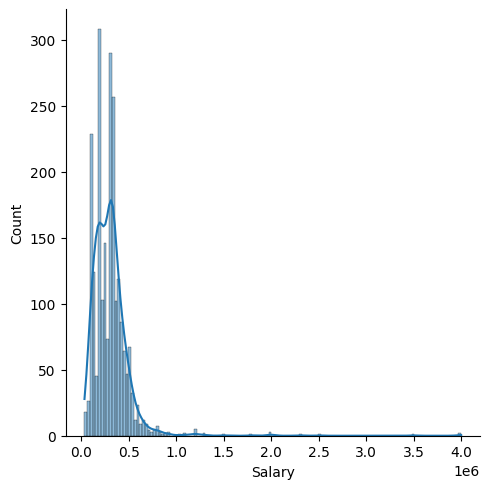

In [23]:
## Rechecking data
plot = sns.displot(train["Salary"], kde=True)

In [24]:
replace_outliers_with_iqr(train, "Salary")

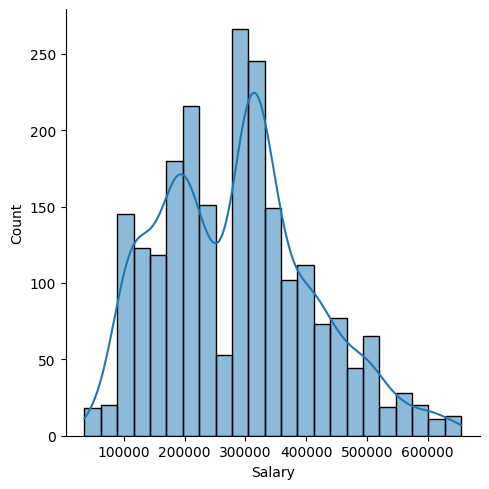

In [25]:
plot = sns.displot(train["Salary"], kde=True)

Text(0.5, 1.0, 'Scatter Plot of 10percentage with 12percentage')

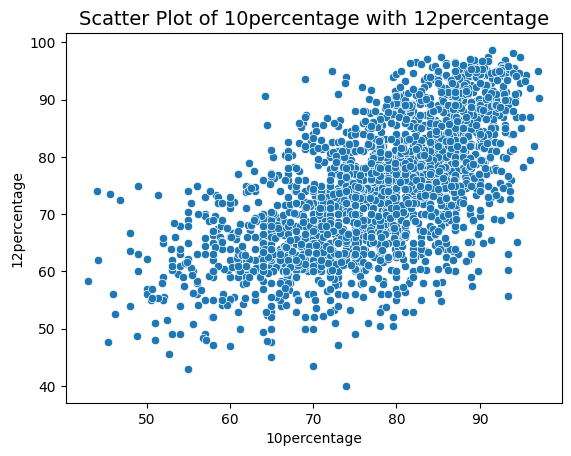

In [26]:
plot = sns.scatterplot(x = train['10percentage'], y=train['12percentage'])
plot.set_title("Scatter Plot of 10percentage with 12percentage", fontsize=14)

In [27]:
train["10percentage"].corr(train["12percentage"])

0.6445183732583881

In [28]:
## Có correlation cao giữa 10percentage và 12percentage, ở đây 12percentage sẽ được sử dụng vì dữ liệu mang tính chất gần kề hơn

Text(0.5, 1.0, 'Scatter Plot of CollegeTier with CollegeCityTier')

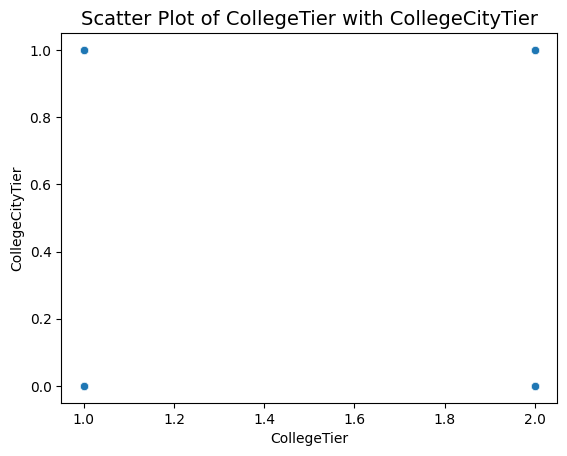

In [29]:
plot = sns.scatterplot(x=train["CollegeTier"], y=train["CollegeCityTier"])
plot.set_title("Scatter Plot of CollegeTier with CollegeCityTier", fontsize=14)

In [30]:
np.abs(train["CollegeTier"].corr(train["CollegeCityTier"]))

0.09306672835171165

In [31]:
## Ở đây mình sẽ loại bỏ CollegeCityTier vì nó không liên quan nhiều đến lương
## Sau khi loại trừ thì chúng ta còn 9 thuộc tính: 
## 'Gender','12percentage', 'Degree', 'collegeGPA','CollegeTier', 'English','Logical', 'Quant','Domain'

In [32]:
model1 = train[['Gender','12percentage', 'Degree', 'collegeGPA','CollegeTier', 'English','Logical', 'Quant','Domain']]
cv_model1 = CrossValidation(model1.to_numpy()[:,:], y_train,10) 
x_1, bias_1 = LinearRegression(model1.to_numpy()[:,:], y_train)
print(cv_model1)


113729.86760853739


In [33]:
model1_test = test[['Gender','12percentage', 'Degree', 'collegeGPA','CollegeTier', 'English','Logical', 'Quant','Domain']]
model1_pred = bias_1 + np.sum(x_1 * model1_test, axis = 1)
MAE(y_test, model1_pred)

105236.59162977398

Model 2: Ảnh hưởng của điểm số các môn học kỹ thuật của AMCAT

In [34]:
subjects = train[['ComputerProgramming','ElectronicsAndSemicon','ComputerScience','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg']]
cv_model2 = CrossValidation(subjects.to_numpy()[:,:], y_train,10) 
x_2, bias_2 = LinearRegression(subjects.to_numpy()[:,:], y_train)
print(cv_model2)

121146.17324643843


In [35]:
plt.figure(figsize=(24,12))
plt.subplots_adjust(wspace=0.3)
cols = 4
rows = 2

for i, s in enumerate(subjects):
    plt.subplot(rows, cols, i + 1)
    sns.scatterplot(x=train[s], y=train['Salary']).set_title(s, fontsize=18)

plt.tight_layout()
plt.show()

In [36]:
model2_test = test[['ComputerProgramming','ElectronicsAndSemicon','ComputerScience','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg']]
model2_pred = bias_2 + np.sum(x_2 * model2_test, axis = 1)
MAE(y_test, model2_pred)

114805.54801929033

Model 3: Lấy những thuộc tính có VIF (Variance Inflation Factor) nhỏ hơn 20

In [37]:
## Calculating VIF (variance inflation factor) to find multicollinearity
vif = pd.DataFrame()
vif["Column"] = train.columns
vif["VIF"] = [variance_inflation_factor(train.values, i) for i in range(len(train.columns))]
vif.drop(vif.index[-1], inplace = True)

vif = vif[vif["VIF"] < 20]

vif

Column        VIF
0                  Gender  10.519143
4                  Degree  16.842509
6         CollegeCityTier   1.485285
10                 Domain   2.896581
11    ComputerProgramming   7.815107
12  ElectronicsAndSemicon   2.139221
13        ComputerScience   1.583824
14         MechanicalEngg   1.402626
15         ElectricalEngg   1.136335
16            TelecomEngg   1.361309
17              CivilEngg   1.029527
18      conscientiousness   1.533646
19          agreeableness   2.038026
20           extraversion   1.437137
21            nueroticism   1.218263
22  openess_to_experience   1.800017

In [38]:
model3 = train[['Gender','Degree','CollegeCityTier', 'Domain', 'ComputerProgramming','ElectronicsAndSemicon','ComputerScience','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg','conscientiousness','agreeableness', 'extraversion', 'nueroticism', 'openess_to_experience']]
cv_model3 = CrossValidation(model3.to_numpy()[:,:], y_train,10) 
x_3, bias_3 = LinearRegression(model3.to_numpy()[:,:], y_train)
print(cv_model3)

118541.02755860848


In [39]:
model3_test = test[['Gender','Degree','CollegeCityTier', 'Domain', 'ComputerProgramming','ElectronicsAndSemicon','ComputerScience','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg','conscientiousness','agreeableness', 'extraversion', 'nueroticism', 'openess_to_experience']]
model3_pred = bias_3 + np.sum(x_3 * model3_test, axis = 1)
MAE(y_test, model3_pred)

111924.33443968225

Model 4 : Chọn top 10 những thuộc tính có cross-validation thấp nhất 

In [40]:
error_list_train, best_index_train = chooseBestProperty(x_train, y_train)
CVTrain = pd.DataFrame() 
CVTrain["Column"] = train.columns
CVTrain.drop(CVTrain.index[-1], inplace = True)
cv_list_train = dict(zip(train.columns, error_list_train))
result = []
for c in cv_list_train: 
    ##print (f'Cross-validation error for {c}: {cv_list_train[c]}')
    result.append(cv_list_train[c])

CVTrain["Cross-validation error"] = [i for i in result]
CVTrain = CVTrain.sort_values(by = 'Cross-validation error')
CVTrain.head(10)

Column  Cross-validation error
9                 Quant           117260.762455
1          10percentage           118988.508613
8               Logical           119998.421336
2          12percentage           120133.567558
7               English           120744.995439
5            collegeGPA           121540.060098
10               Domain           122123.418172
11  ComputerProgramming           122763.622475
3           CollegeTier           123310.456389
21          nueroticism           123435.415505

In [49]:
model4 = train[['Quant', '10percentage', 'Logical', '12percentage', 'English', 'collegeGPA', 'Domain', 'ComputerProgramming','CollegeTier','nueroticism']]
cv_model4 = CrossValidation(model4.to_numpy()[:,:], y_train,10) 
x_4, bias_4 = LinearRegression(model4.to_numpy()[:,:], y_train)
print(cv_model4)

113521.68155814658


In [42]:
model4_test = test[['Quant', '10percentage', 'Logical', '12percentage', 'English', 'collegeGPA', 'Domain', 'ComputerProgramming','CollegeTier','nueroticism']]
model4_pred = bias_4 + np.sum(x_4 * model4_test, axis = 1)
MAE(y_test, model4_pred)

104324.43323106658

## Thử nghiệm, so sánh các mô hình

In [50]:
# Phần code cho yêu cầu 1d
# Tìm ra mô hình tốt nhất (tự thiết kế bởi sinh viên)
# In ra các kết quả cross-validation như yêu cầu

cross_val = []
cross_val.append(cv_model1)
cross_val.append(cv_model2)
cross_val.append(cv_model3)
cross_val.append(cv_model4)

cv = pd.DataFrame()
cv["Model name"] = ['Reprocessed first 11 attributes','Scores in AMCAT technical subjects','Attributes having VIF < 20','Top 10 Attributes having smallest CV error']
cv['Cross-validation error'] = [c for c in cross_val]

cv

Model name  Cross-validation error
0             Reprocessed first 11 attributes           113729.867609
1          Scores in AMCAT technical subjects           121146.173246
2                  Attributes having VIF < 20           118541.027559
3  Top 10 Attributes having smallest CV error           113521.681558

In [51]:
mae_list = []
mae_list.append(MAE(y_test, model1_pred))
mae_list.append(MAE(y_test, model2_pred))
mae_list.append(MAE(y_test, model3_pred))
mae_list.append(MAE(y_test, model4_pred))

models = pd.DataFrame()
models["Model name"] = ['Reprocessed first 11 attributes','Scores in AMCAT technical subjects','Attributes having VIF < 20','Top 10 Attributes having smallest CV error']
models["MAE"] = [m for m in mae_list]

models

Model name            MAE
0             Reprocessed first 11 attributes  105236.591630
1          Scores in AMCAT technical subjects  114805.548019
2                  Attributes having VIF < 20  111924.334440
3  Top 10 Attributes having smallest CV error  104324.433231

In [52]:
## Conclusion: Best model of the 4 is "Top 10 Attributes having smallest CV error"

In [53]:
x_4 = np.array2string(x_4, precision=3, separator=',',suppress_small=True)
findFormula(x_4, bias_4)

Intercept: 
 71626.09348183172
Coefficients: 
 [   128.601,   529.78 ,   120.956,  1062.286,   131.316,  1083.743,
  26282.433,    67.969,-99901.372, -4558.527]


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 71626.094 + 128.601{Quant} + 529.780{10percentage} + 120.956{Logical} + 1062.287{12percentage} 
+ 131.316{English}\\ + 1083.743{collegeGPA} - 26282.433{Domain} + 67.969{ComputerProgramming} + -99901.372{CollegeTier} -4588.527{Nueroticism}$$